# StyleGAN3 Training — Latent Resonance Spectrograms (Kaggle)

Train StyleGAN3 on 512x512 grayscale spectrogram images.

**Setup:** In the Kaggle sidebar, go to **Settings → Accelerator → GPU T4 x2**.

**Dataset:** Upload your `spectrograms.zip` as a [Kaggle Dataset](https://www.kaggle.com/datasets),
then add it to this notebook via **Add data** in the sidebar.

## 1. Setup & GPU Check

In [1]:
!nvidia-smi
!pip install -q ninja

import torch
assert torch.cuda.is_available(), "No GPU — enable it in Settings → Accelerator → GPU T4 x2"
print(f"PyTorch {torch.__version__}, CUDA {torch.version.cuda}, GPU: {torch.cuda.get_device_name(0)}")

Mon Feb  2 06:35:08 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.105.08             Driver Version: 580.105.08     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Clone StyleGAN3 & Apply Patches

In [2]:
import os
import sys
import pathlib
import shutil
import subprocess

# Fresh clone
if os.path.exists("stylegan3"):
    shutil.rmtree("stylegan3")
!git clone https://github.com/NVlabs/stylegan3.git
sys.path.insert(0, "stylegan3")

# ── Patch 1: Fix InfiniteSampler for PyTorch ≥2.4 ────────────────────────
misc_path = pathlib.Path("stylegan3/torch_utils/misc.py")
src = misc_path.read_text()
src = src.replace("super().__init__(dataset)", "super().__init__()")
misc_path.write_text(src)
print(f"Patched {misc_path}: InfiniteSampler fix")

# ── Patch 2: Fix Adam betas int → float for PyTorch ≥2.9 ────────────────
train_path = pathlib.Path("stylegan3/train.py")
src = train_path.read_text()
src = src.replace("betas=[0,0.99]", "betas=[0.0,0.99]")
train_path.write_text(src)
print(f"Patched {train_path}: Adam betas fix")

# ── Patch 3: Try CUDA ops compilation ────────────────────────────────────
# Detect GPU compute capability automatically
cc_major, cc_minor = torch.cuda.get_device_capability(0)
arch = f"{cc_major}.{cc_minor}"
os.environ["TORCH_CUDA_ARCH_LIST"] = arch
os.environ["TORCH_EXTENSIONS_DIR"] = "/tmp/torch_extensions"
if os.path.exists("/tmp/torch_extensions"):
    shutil.rmtree("/tmp/torch_extensions")

result = subprocess.run(
    ["python", "-c",
     "import sys; sys.path.insert(0,'stylegan3'); "
     "from torch_utils.ops import bias_act; "
     "assert bias_act._init(), 'init failed'"],
    capture_output=True, text=True, timeout=180,
)

CUDA_OPS_OK = result.returncode == 0
if CUDA_OPS_OK:
    print(f"Custom CUDA ops compiled for sm_{cc_major}{cc_minor} — using fused kernels")
else:
    print(f"CUDA ops compilation failed (arch {arch}), using native PyTorch fallback")
    print(f"  Error: ...{result.stderr[-300:]}")
    ops_dir = pathlib.Path("stylegan3/torch_utils/ops")
    for name in ["bias_act.py", "upfirdn2d.py", "filtered_lrelu.py"]:
        p = ops_dir / name
        s = p.read_text()
        s = s.replace("def _init():", "def _init():\n    return False")
        p.write_text(s)
        print(f"  Patched {p}")

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 212 (delta 99), reused 90 (delta 90), pack-reused 49 (from 1)
Receiving objects: 100% (212/212), 4.16 MiB | 22.91 MiB/s, done.
Resolving deltas: 100% (108/108), done.
Patched stylegan3/torch_utils/misc.py: InfiniteSampler fix
Patched stylegan3/train.py: Adam betas fix
Custom CUDA ops compiled for sm_75 — using fused kernels


## 3. Load Dataset

Kaggle datasets are mounted at `/kaggle/input/<dataset-name>/`.

Set `KAGGLE_DATASET` to match your dataset name.

In [3]:
import os
import glob
import shutil

KAGGLE_DATASET = "spectrograms"  # <-- your Kaggle dataset name

input_dir = f"/kaggle/input/{KAGGLE_DATASET}"

# Find PNGs (may be in root or a subfolder)
pngs = glob.glob(f"{input_dir}/**/*.png", recursive=True)

# Copy to a writable working directory (Kaggle input is read-only)
DATASET_PATH = "/kaggle/working/spectrograms"
os.makedirs(DATASET_PATH, exist_ok=True)
for p in pngs:
    shutil.copy(p, DATASET_PATH)

print(f"Found {len(pngs)} PNG files → copied to {DATASET_PATH}")

Found 489 PNG files → copied to /kaggle/working/spectrograms


## 4. Prepare Dataset

In [4]:
!python stylegan3/dataset_tool.py \
    --source={DATASET_PATH} \
    --dest=./spectrograms.zip \
    --resolution=512x512

  0%|                                                   | 0/489 [00:00<?, ?it/s]/kaggle/working/stylegan3/dataset_tool.py:441: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = PIL.Image.fromarray(img, { 1: 'L', 3: 'RGB' }[channels])
100%|████████████████████████████████████████| 489/489 [00:04<00:00, 115.46it/s]


import os
os.environ["PYTORCH_ALLOC_CONF"] = "expandable_segments:True"

GPUS = 2             # Kaggle T4 x2 — use both, halves per-GPU memory
GAMMA = 2.0
SNAP = 10
KIMG = 5000
CFG = "stylegan3-t"
MIRROR = False
METRICS = "none"
RESUME = ""

if CUDA_OPS_OK:
    BATCH_SIZE = 16
    CBASE = 32768
    CMAX = 512
    MBSTD = 4
    print(f"CUDA ops available — batch={BATCH_SIZE}, full model capacity")
else:
    BATCH_SIZE = 4       # 2 per GPU
    CBASE = 8192
    CMAX = 128
    MBSTD = 2
    print(f"Native fallback — batch={BATCH_SIZE} ({BATCH_SIZE // GPUS} per GPU), cbase={CBASE}, cmax={CMAX}")

In [8]:
import os
os.environ["PYTORCH_ALLOC_CONF"] = "expandable_segments:True"

GPUS = 2
GAMMA = 2.0
SNAP = 10
KIMG = 500
CFG = "stylegan3-t"
MIRROR = False
METRICS = "none"
RESUME = "/kaggle/working/training-runs/00005-stylegan3-t-spectrograms-gpus2-batch8-gamma2/network-snapshot-000200.pkl"

if CUDA_OPS_OK:
    BATCH_SIZE = 8
    CBASE = 8192
    CMAX = 128
    MBSTD = 4
    print(f"CUDA ops available — batch={BATCH_SIZE}, full model capacity")
else:
    BATCH_SIZE = 2
    CBASE = 8192
    CMAX = 128
    MBSTD = 2
    print(f"Native fallback — batch={BATCH_SIZE}, cbase={CBASE}, cmax={CMAX}")

CUDA ops available — batch=8, full model capacity


## 6. Train

In [9]:
import torch
torch.cuda.empty_cache()

resume_flag = f"--resume={RESUME}" if RESUME else ""
mirror_int = 1 if MIRROR else 0

!python stylegan3/train.py \
    --outdir=./training-runs \
    --cfg={CFG} \
    --data=./spectrograms.zip \
    --gpus={GPUS} \
    --batch={BATCH_SIZE} \
    --batch-gpu={BATCH_SIZE // GPUS} \
    --gamma={GAMMA} \
    --snap={SNAP} \
    --kimg={KIMG} \
    --mirror={mirror_int} \
    --metrics={METRICS} \
    --cbase={CBASE} \
    --cmax={CMAX} \
    --mbstd-group={MBSTD} \
    {resume_flag}


Training options:
{
  "G_kwargs": {
    "class_name": "training.networks_stylegan3.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "channel_base": 8192,
    "channel_max": 128,
    "magnitude_ema_beta": 0.9997227795604651
  },
  "D_kwargs": {
    "class_name": "training.networks_stylegan2.Discriminator",
    "block_kwargs": {
      "freeze_layers": 0
    },
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 8192,
    "channel_max": 128
  },
  "G_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0.0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.0025
  },
  "D_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0.0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.002
  },
  "loss_kwargs": {
    "class_name": "training.loss.StyleGAN2Loss",
    "r1_gamma": 2.0,
    "blur_init_sigma": 0
  },
  "data_loader_kwargs": {
    "pin_memor

## 7. Generate Samples

Loading training-runs/00011-stylegan3-t-spectrograms-gpus2-batch8-gamma2/network-snapshot-000400.pkl


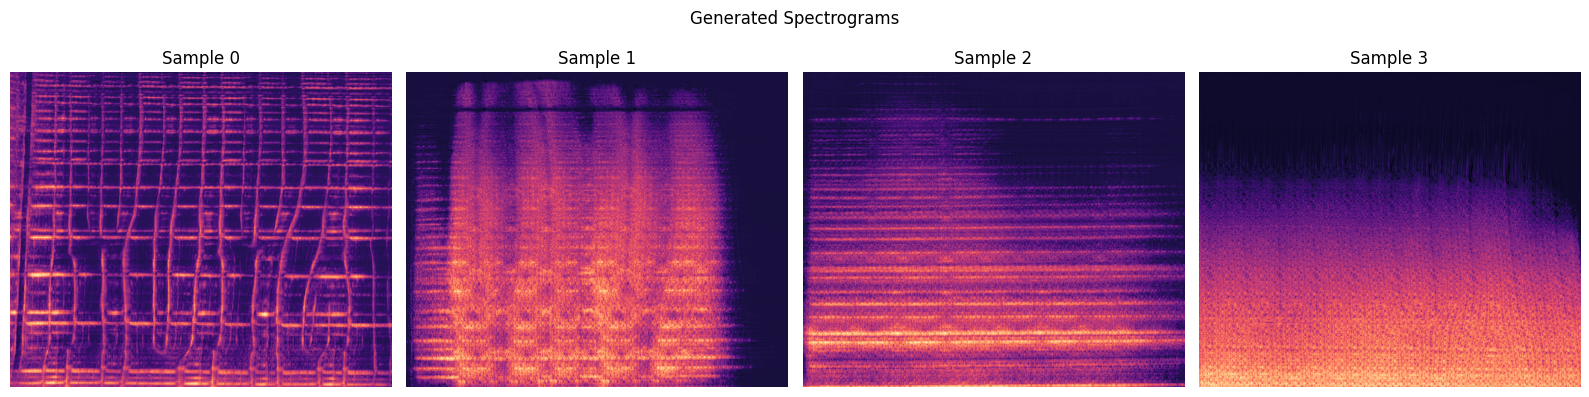

In [10]:
import glob
import pickle

import matplotlib.pyplot as plt
import torch

pkls = sorted(glob.glob("training-runs/**/*.pkl", recursive=True))
assert pkls, "No snapshots found — has training completed at least one snapshot?"
latest_pkl = pkls[-1]
print(f"Loading {latest_pkl}")

with open(latest_pkl, "rb") as f:
    G = pickle.load(f)["G_ema"].cuda().eval()

z = torch.randn(4, G.z_dim, device="cuda")
with torch.no_grad():
    imgs = G(z, None)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axes):
    img = imgs[i, 0].cpu().numpy()
    ax.imshow(img, cmap="magma", aspect="auto")
    ax.set_title(f"Sample {i}")
    ax.axis("off")
plt.suptitle("Generated Spectrograms")
plt.tight_layout()
plt.show()

## 8. Save Results

Kaggle persists everything in `/kaggle/working/` as notebook output.
Click **Save Version** (top right) → the training-runs zip will be available under **Output**.

In [11]:
import shutil

shutil.make_archive("/kaggle/working/training-runs", "zip", ".", "training-runs")
print("Created /kaggle/working/training-runs.zip")
print("This will be saved as notebook output when you click Save Version.")

KeyboardInterrupt: 